In [13]:
import pandas as pd
from ast import literal_eval
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np

# Load the dataset
data = pd.read_csv("/content/Dataset m2 csv2 snip.csv")

# Convert string representations of lists to actual lists
data["word_tokens"] = data["word_tokens"].apply(lambda x: literal_eval(str(x)) if isinstance(x, str) else [])

# Extract relevant columns
text_data = data["text"].tolist()
word_tokens = data["word_tokens"].tolist()

# Convert float values to strings in text_data
text_data = [str(item) for item in text_data]

# Concatenate all lyrics into a single string for vocabulary creation
all_lyrics = ' '.join(text_data)

# Tokenize the text and create vocabulary
tokenizer = Tokenizer()
tokenizer.fit_on_texts([all_lyrics])

# Convert words to integers based on the vocabulary
sequences = tokenizer.texts_to_sequences(text_data)

# Create input-output sequences
input_sequences = []
output_sequences = []
for sequence in sequences:
    for i in range(1, len(sequence)):
        input_sequence = sequence[:i]
        output_sequence = sequence[i]
        input_sequences.append(input_sequence)
        output_sequences.append(output_sequence)

# Pad sequences to ensure uniform length
max_sequence_length = max([len(seq) for seq in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='pre')
output_sequences = to_categorical(output_sequences, num_classes=len(tokenizer.word_index) + 1)



In [14]:
# Define a generator function
def sequence_generator(sequences, output_sequences, batch_size):
    num_samples = len(sequences)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_input_sequences = sequences[offset:offset+batch_size]
            batch_output_sequences = output_sequences[offset:offset+batch_size]
            yield batch_input_sequences, batch_output_sequences

# Define parameters
batch_size = 32  # Define your desired batch size

# Create a generator
generator = sequence_generator(input_sequences, output_sequences, batch_size)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Define the model
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_sequence_length),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dense(len(tokenizer.word_index) + 1, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [16]:
import pandas as pd
from ast import literal_eval
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(input_sequences, output_sequences, test_size=0.2, random_state=42)


# Define a data generator function
def data_generator(input_sequences, output_sequences, batch_size):
    total_sequences = len(input_sequences)
    while True:
        for start in range(0, total_sequences, batch_size):
            end = min(start + batch_size, total_sequences)
            yield input_sequences[start:end], output_sequences[start:end]

# Set batch size
batch_size = 128

# Define number of epochs
epochs = 2

# Train the model using fit_generator
model.fit_generator(data_generator(X_train, y_train, batch_size),
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=epochs,
                    validation_data=data_generator(X_val, y_val, batch_size),
                    validation_steps=len(X_val) // batch_size)

Epoch 1/2


<ipython-input-16-712df1169534>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(data_generator(X_train, y_train, batch_size),


181/181 [==============================] - 681s 4s/step - loss: 6.7051 - accuracy: 0.0417 - val_loss: 6.4619 - val_accuracy: 0.0441
Epoch 2/2
181/181 [==============================] - 689s 4s/step - loss: 6.3355 - accuracy: 0.0418 - val_loss: 6.3591 - val_accuracy: 0.0440


In [17]:
def generate_lyrics(seed_text, model, tokenizer, max_sequence_length, num_words):
    output_text = seed_text
    input_sequence = tokenizer.texts_to_sequences([seed_text])[0]

    for _ in range(num_words):
        padded_sequence = pad_sequences([input_sequence], maxlen=max_sequence_length, padding='pre')
        predicted_index = np.argmax(model.predict(padded_sequence), axis=-1)
        predicted_word = tokenizer.index_word.get(predicted_index[0], '')
        output_text += ' ' + predicted_word
        input_sequence.append(predicted_index[0])

    return output_text

# Example usage
seed_text = "i have tried in vain"
generated_lyrics = generate_lyrics(seed_text, model, tokenizer, max_sequence_length, num_words=50)
print(generated_lyrics)


1/1 [==============================] - 0s 121ms/step
i have tried in vain the the the the the and the and the and the and the and the and the and the and the and the and the and the and the and the and the and the the the the the the the the the the the the the the the the


Validation Loss: 6.353457927703857
Validation Accuracy: 0.04410751163959503


NameError: name 'history' is not defined

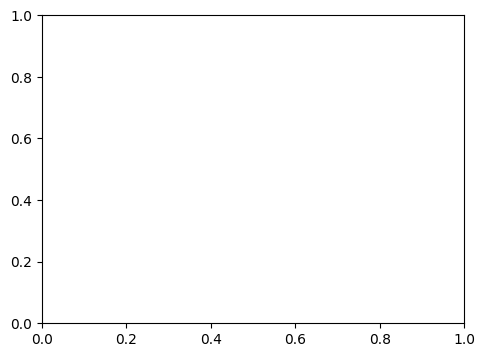

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model
evaluation = model.evaluate(X_val, y_val, verbose=0)
loss = evaluation[0]
accuracy = evaluation[1]
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

# Assuming 'history' is obtained during the training process
# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# If you need to generate predictions and compute metrics like classification report:
# (Assuming you have a classification model. Adjust for text generation tasks)

# Predict on validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Generate classification report and confusion matrix
print(classification_report(y_true, y_pred_classes))
print(confusion_matrix(y_true, y_pred_classes))


Epoch 1/2
181/181 [==============================] - 691s 4s/step - loss: 6.1705 - accuracy: 0.0424 - val_loss: 6.3160 - val_accuracy: 0.0476
Epoch 2/2
181/181 [==============================] - 688s 4s/step - loss: 6.0199 - accuracy: 0.0469 - val_loss: 6.1927 - val_accuracy: 0.0532
Validation Loss: 6.186961650848389
Validation Accuracy: 0.05358373373746872


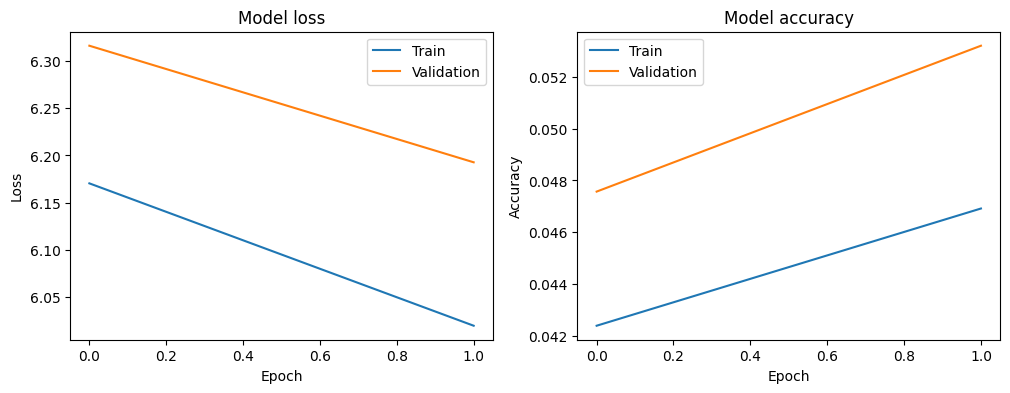

1/1 [==============================] - 0s 268ms/step
i have tried in vain i love and the world and the world of the love of the love of the love of the love of the love of the love of the love of the love of the love of the love of the love of the love of the love of the love


In [19]:
# Train the model using fit_generator
history = model.fit(data_generator(X_train, y_train, batch_size),
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=epochs,
                    validation_data=data_generator(X_val, y_val, batch_size),
                    validation_steps=len(X_val) // batch_size)

# Evaluate the model
evaluation = model.evaluate(X_val, y_val, verbose=0)
loss, accuracy = evaluation
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Function to generate lyrics
def generate_lyrics(seed_text, model, tokenizer, max_sequence_length, num_words):
    output_text = seed_text
    input_sequence = tokenizer.texts_to_sequences([seed_text])[0]

    for _ in range(num_words):
        padded_sequence = pad_sequences([input_sequence], maxlen=max_sequence_length, padding='pre')
        predicted_index = np.argmax(model.predict(padded_sequence), axis=-1)
        predicted_word = tokenizer.index_word.get(predicted_index[0], '')
        output_text += ' ' + predicted_word
        input_sequence.append(predicted_index[0])

    return output_text

# Example usage
seed_text = "i have tried in vain"
generated_lyrics = generate_lyrics(seed_text, model, tokenizer, max_sequence_length, num_words=50)
print(generated_lyrics)